In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## I. Import and explore training data

In [2]:
df_train = pd.read_csv('/content/housePrices_train.csv')
df_test = pd.read_csv('/content/housePrices_test.csv')

print(df_train.shape, df_test.shape)

(1460, 81) (1459, 80)


### 1.1. Take a look at our target 'SalePrice'
We can use a summary from descriptive statistics and a histogram to overview our 'y', the target we are modelling for.

In [3]:
df_train['SalePrice'].describe()

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


The minimum is larger than zero. The mean is higher than 50% quantile, from where we see the effect of highest prices on the mean.

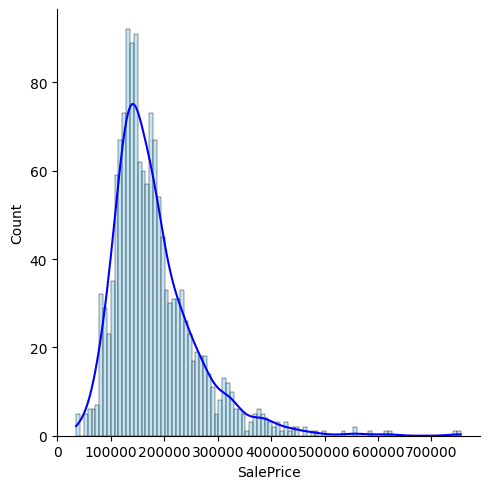

In [4]:
displot = sns.displot(df_train['SalePrice'], color = 'skyblue', bins = 100,
                      kind = 'hist', kde = True)

ax = displot.axes[0,0]
kde_line = ax.lines[0]
kde_line.set_color('blue')

plt.show()

From this histogram we can see more:

1. positive skewness(正偏差): The distribution is not normal because of few high values. The right tail means few highest prices increase the mean. Can use `df_train['SalePrice'].skew()` to see how far it is from normal distribution (skewness≈0)
2. peakedness: there is a peak value. Can use `df_train['SalePrice'].kurt()` to quantify the kurtosis. Normal distribution would have kurtosis ≈ 3.

### 1.2. Missing data?

Make a table to look at total counts and percantages of missing values. Variables whose missing percentage > 15% will be removed from the training data.

In [5]:
total = df_train.isnull().sum().sort_values(ascending = False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending = False)

missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageQual,81,0.055479
GarageFinish,81,0.055479
GarageType,81,0.055479


In [6]:
df_train = df_train.drop((missing_data[missing_data['Percent'] > 0.15]).index, axis = 1)
df_test = df_test.drop((missing_data[missing_data['Percent'] > 0.15]).index, axis = 1)

In [7]:
print(df_train.shape, df_test.shape)
print(df_train.columns[-5:])

(1460, 74) (1459, 73)
Index(['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice'], dtype='object')


## II. Feature selection


### 2.1. Correlation matrix for numeric features

Good features are features highly correlated to the target but uncorrelated among themselves. From the correlation matrix we can identify both.

Since Pearson correlation works best when data is normal distributed but we already know SalePrice is not a normal distribution. Therefore, we do log transform first and then make correlation matrix.

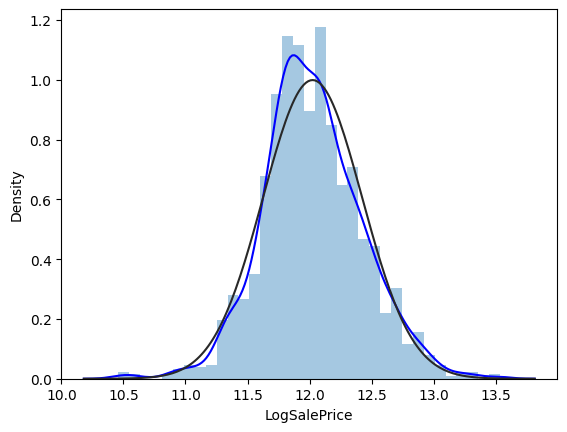

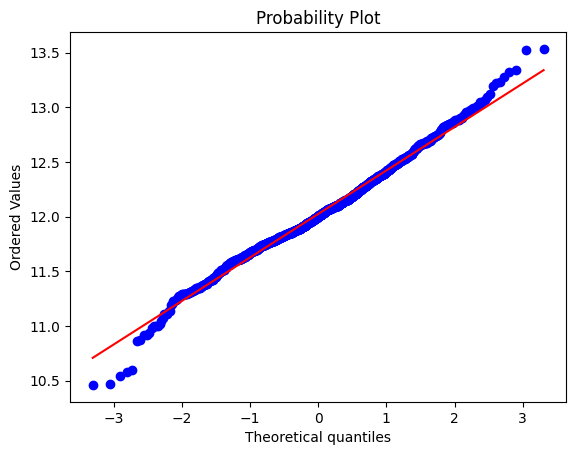

In [8]:
df_train['LogSalePrice'] = np.log(df_train['SalePrice'])

# plot histogram with normal dist line
from scipy.stats import norm
sns.distplot(df_train['LogSalePrice'], fit=norm, kde=True, kde_kws={'color': 'blue'})
plt.show()

# plot residues
fig = plt.figure()
res = stats.probplot(df_train['LogSalePrice'], plot = plt)

(1460, 38)


<Axes: >

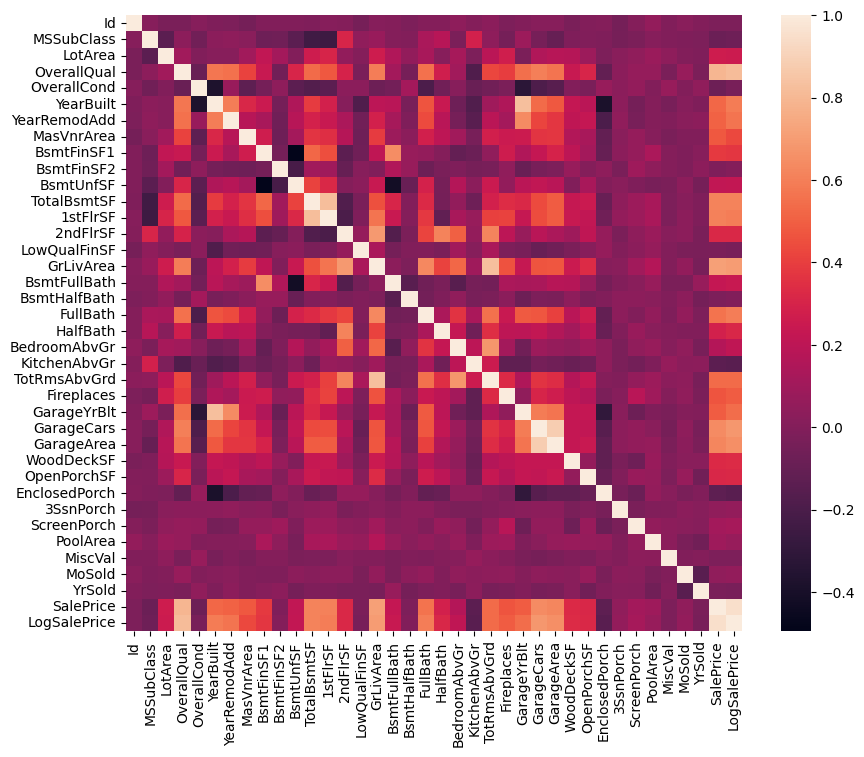

In [9]:
# calc the correlation
numeric_features = df_train.select_dtypes(include=[np.number])
print(numeric_features.shape)
cor = numeric_features.corr()

# plot as heatmap
f, ax = plt.subplots(figsize = (10,8))
sns.heatmap(cor, square= True)

After this overview, we can plot a second correlation map using those features highly correlated to SalePrice. And from there we can see if the features are correlated among each other.

In [10]:
print(cor['LogSalePrice'].sort_values(ascending = False))

LogSalePrice     1.000000
SalePrice        0.948374
OverallQual      0.817184
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
YearBuilt        0.586570
YearRemodAdd     0.565608
GarageYrBlt      0.541073
TotRmsAbvGrd     0.534422
Fireplaces       0.489449
MasVnrArea       0.430809
BsmtFinSF1       0.372023
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209044
ScreenPorch      0.121208
PoolArea         0.069798
MoSold           0.057329
3SsnPorch        0.054900
BsmtFinSF2       0.004832
BsmtHalfBath    -0.005149
Id              -0.017942
MiscVal         -0.020021
OverallCond     -0.036868
YrSold          -0.037263
LowQualFinSF    -0.037963
MSSubClass      -0.073959
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
Name: LogSal

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'SalePrice', 'LogSalePrice'],
      dtype='object')


<Axes: >

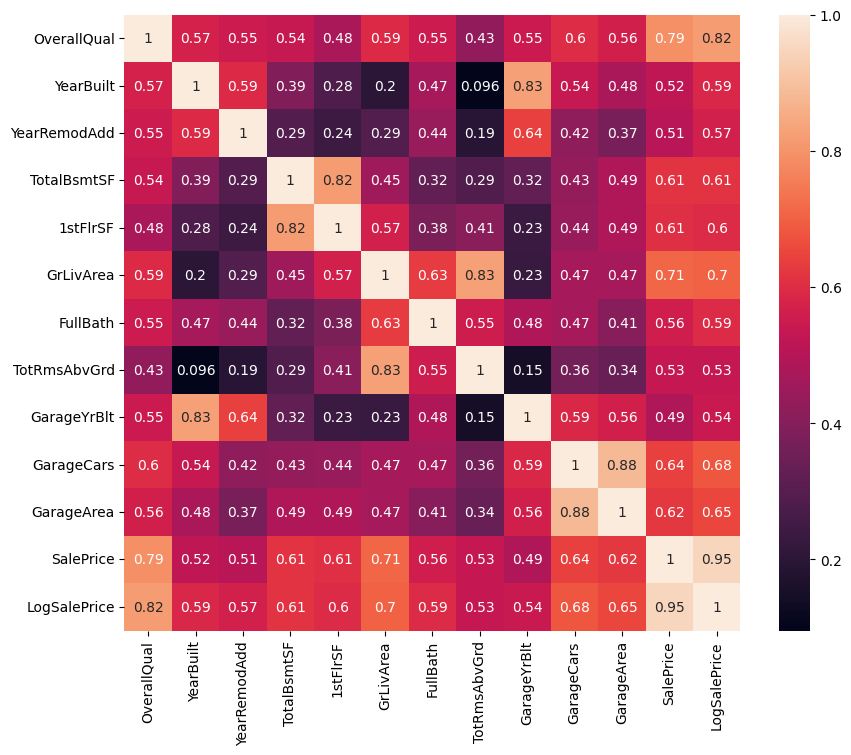

In [11]:
high_cor = cor['LogSalePrice'][cor['LogSalePrice'].abs() > 0.5].index
print(high_cor)

cm = df_train[high_cor].corr()

plt.figure(figsize = (10,8))
sns.heatmap(cm, square = True, annot = True)

OverallQual      0.817184

GrLivArea        0.700927

GarageCars       0.680625

GarageArea       0.650888 -> highly correlated to GarageCars

TotalBsmtSF      0.612134

1stFlrSF         0.596981 -> highly correlated to TotalBsmtSF

FullBath         0.594771

YearBuilt        0.586570

YearRemodAdd     0.565608

GarageYrBlt      0.541073 -> highly correlated to YearBuilt

TotRmsAbvGrd     0.534422 -> highly correlated to GrLivArea

After removing four colinear features, we can move on to modelling using the rest 7 features.

### 2.2. Categorical features

First take an overview of categorical data.

In [12]:
# get col names of categorical data
cat_cols = df_train.select_dtypes(include = 'object').columns

# summary of categorical data
cat_summary = pd.DataFrame({
    'Feature': cat_cols,
    'Types': [df_train[col].nunique() for col in cat_cols],
    'Sample values': [df_train[col].dropna().unique()[:2] for col in cat_cols]
})

cat_summary

,Feature,Types,Sample values
0,MSZoning,5,"[RL, RM]"
1,Street,2,"[Pave, Grvl]"
2,LotShape,4,"[Reg, IR1]"
3,LandContour,4,"[Lvl, Bnk]"
4,Utilities,2,"[AllPub, NoSeWa]"
5,LotConfig,5,"[Inside, FR2]"
6,LandSlope,3,"[Gtl, Mod]"
7,Neighborhood,25,"[CollgCr, Veenker]"
8,Condition1,9,"[Norm, Feedr]"
9,Condition2,8,"[Norm, Artery]"


In [13]:
# split features into two groups by num of types
cat_counts = df_train[cat_cols].nunique()
#cat_counts.head(5)

threshold = 10
onehot = cat_counts[cat_counts <= threshold].index
target = cat_counts[cat_counts > threshold].index
print(onehot, target)

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object') Index(['Neighborhood', 'Exterior1st', 'Exterior2nd'], dtype='object')


In [14]:
# one-hot encodiing
# Combine df_train and df_test *before* encoding to ensure column alignment
combined = pd.concat([df_train[onehot], df_test[onehot]], axis=0)

# Perform one-hot encoding on combined data
combined_onehot = pd.get_dummies(combined, drop_first=True)

# Split back
df_onehot = combined_onehot.iloc[:df_train.shape[0]].reset_index(drop=True)
test_onehot = combined_onehot.iloc[df_train.shape[0]:].reset_index(drop=True)
print(df_onehot.shape, test_onehot.shape)

(1460, 140) (1459, 140)


In [15]:
# target mean encoding
df_target = pd.DataFrame(index = df_train.index)

for col in target:
  target_mean = df_train.groupby(col)['LogSalePrice'].mean()
  df_target[col] = df_train[col].map(target_mean)

print(df_target.shape)
print(df_target.head(5))

(1460, 3)
   Neighborhood  Exterior1st  Exterior2nd
0     12.163641    12.205873    12.209631
1     12.344176    11.859767    11.862286
2     12.163641    12.205873    12.209631
3     12.206659    11.838506    11.892242
4     12.676000    12.205873    12.209631


## III. Find outliers
We can use scatter plots (bivariate method) to find outliers.

In [47]:
df_train = df_train[df_train['Id'] != 1299]
df_train = df_train[df_train['Id'] != 524]

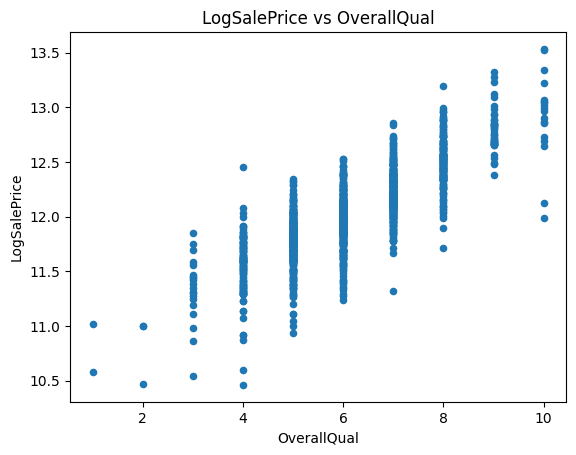

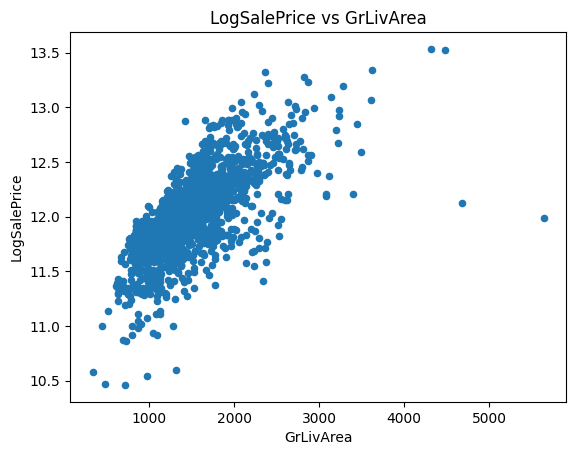

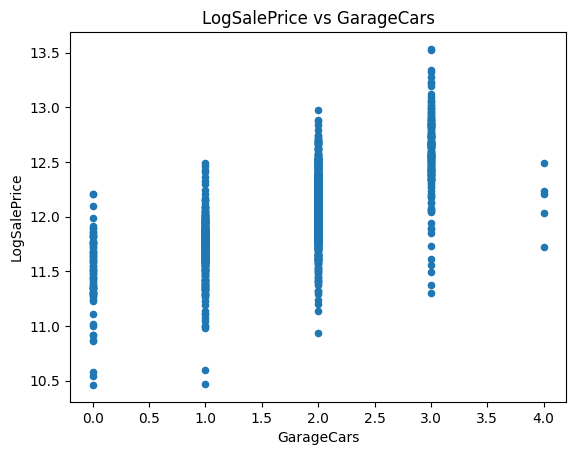

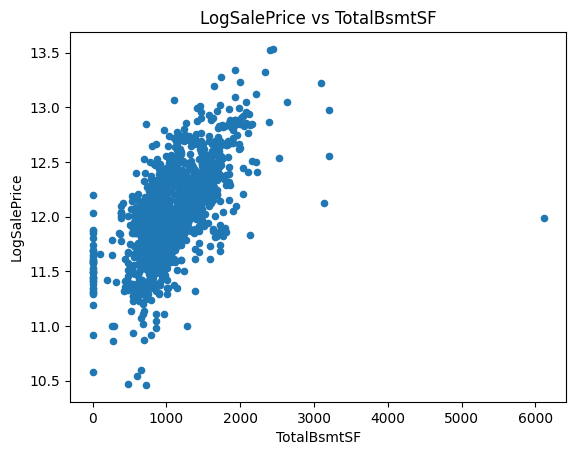

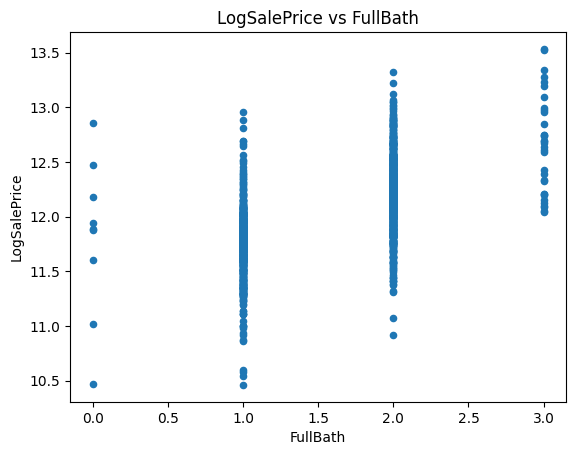

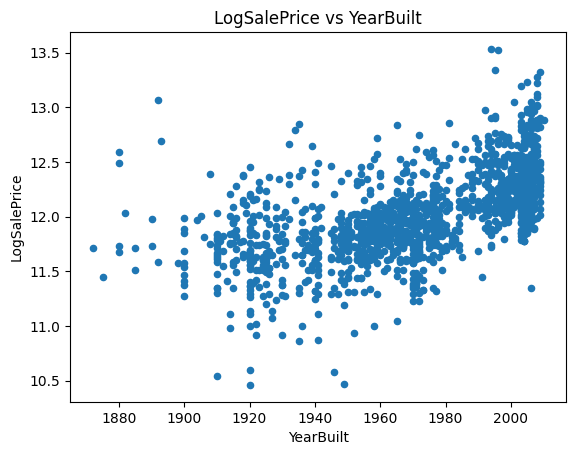

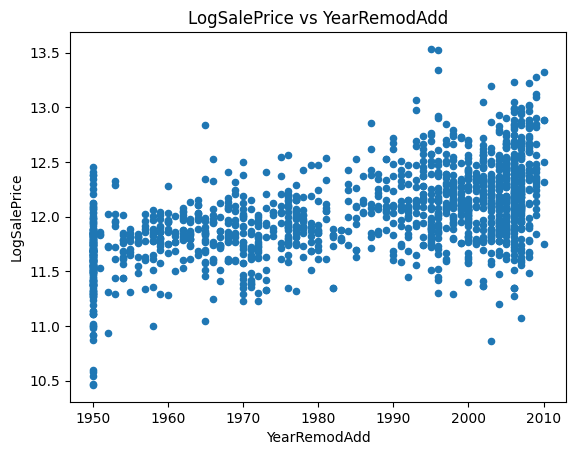

In [16]:
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd']

for var in cols:
  dat = pd.concat([df_train['LogSalePrice'], df_train[var]], axis = 1)
  dat.plot.scatter(x = var, y = 'LogSalePrice')
  plt.title(f'LogSalePrice vs {var}')
  plt.show()

From here we can see three outlier points: two in GrLivArea and one in TotalBsmtSF. Let's remove them to get our final training data.

In [17]:
df_train.sort_values(by = 'GrLivArea', ascending = False)['Id'].head(2)

,Id
1298,1299
523,524


In [18]:
df_train.sort_values(by = 'TotalBsmtSF', ascending = False)['Id'].head(1)

,Id
1298,1299


In [19]:
# remove outliars from training data
outlier_ids = [1299, 524]

df_train = df_train[~df_train['Id'].isin(outlier_ids)]

# df_onehot and df_target has no Id columns, so we use row index to remove
filtered_index = df_train.index
df_onehot = df_onehot.loc[filtered_index]
df_target = df_target.loc[filtered_index]

print(df_train.shape, df_onehot.shape, df_target.shape)

(1458, 75) (1458, 140) (1458, 3)


In [20]:
print(df_train.head(5))

   Id  MSSubClass MSZoning  LotArea Street LotShape LandContour Utilities  \
0   1          60       RL     8450   Pave      Reg         Lvl    AllPub   
1   2          20       RL     9600   Pave      Reg         Lvl    AllPub   
2   3          60       RL    11250   Pave      IR1         Lvl    AllPub   
3   4          70       RL     9550   Pave      IR1         Lvl    AllPub   
4   5          60       RL    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope  ... 3SsnPorch ScreenPorch PoolArea MiscVal MoSold  \
0    Inside       Gtl  ...         0           0        0       0      2   
1       FR2       Gtl  ...         0           0        0       0      5   
2    Inside       Gtl  ...         0           0        0       0      9   
3    Corner       Gtl  ...         0           0        0       0      2   
4       FR2       Gtl  ...         0           0        0       0     12   

   YrSold  SaleType  SaleCondition  SalePrice LogSalePrice  
0    2008        WD

# IV. Let's do Modelling



## 4.1. XGboost regression - using only correlated numerical data

In [22]:
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [23]:
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd']

# training data
x_train = df_train[cols]
x_train = x_train.round(2)
y_train = df_train['LogSalePrice']

# testing data
x_test = df_test[cols]

In [24]:
model = xgb.XGBRegressor(n_estimators = 300,
                         learning_rate = 0.1,
                         random_state = 123
                         )

In [25]:
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

In [26]:
y_pred_log = model.predict(x_test)
y_pred = np.exp(y_pred_log)

In [27]:
# training RMSE
train_preds = model.predict(x_train)
rmse = np.sqrt(mean_squared_error(y_train, train_preds))
print(rmse)

0.03410703536175737


## 4.2. Lasso - using all features as input

In [28]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

In [32]:
df_numeric = df_train.drop(columns = cat_cols.tolist() + ['Id', 'SalePrice', 'LogSalePrice'])
df_numeric = df_numeric.round(3)

In [33]:
print("Shape of df_numeric:", df_numeric.shape)
print("Shape of df_onehot:", df_onehot.shape)
print("Shape of df_target:", df_target.shape)

Shape of df_numeric: (1458, 35)
Shape of df_onehot: (1458, 140)
Shape of df_target: (1458, 3)


In [34]:
X_train = pd.concat([df_numeric, df_onehot, df_target], axis = 1)
y_train = df_train['LogSalePrice']

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns, index=X_train.index)

In [35]:
print(X_train.shape, X_train_imputed.shape)
print(y_train.shape)
print(df_onehot.index)

(1458, 178) (1458, 178)
(1458,)
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459],
      dtype='int64', length=1458)


In [41]:
alphas = np.logspace(-4, 0, 50)
model_lasso = LassoCV(alphas=alphas, cv=5, max_iter=10000).fit(X_train_imputed, y_train)

#model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train_imputed, y_train)

In [42]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train_imputed, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

rmse_cv(model_lasso).mean()

np.float64(0.1163048901998502)

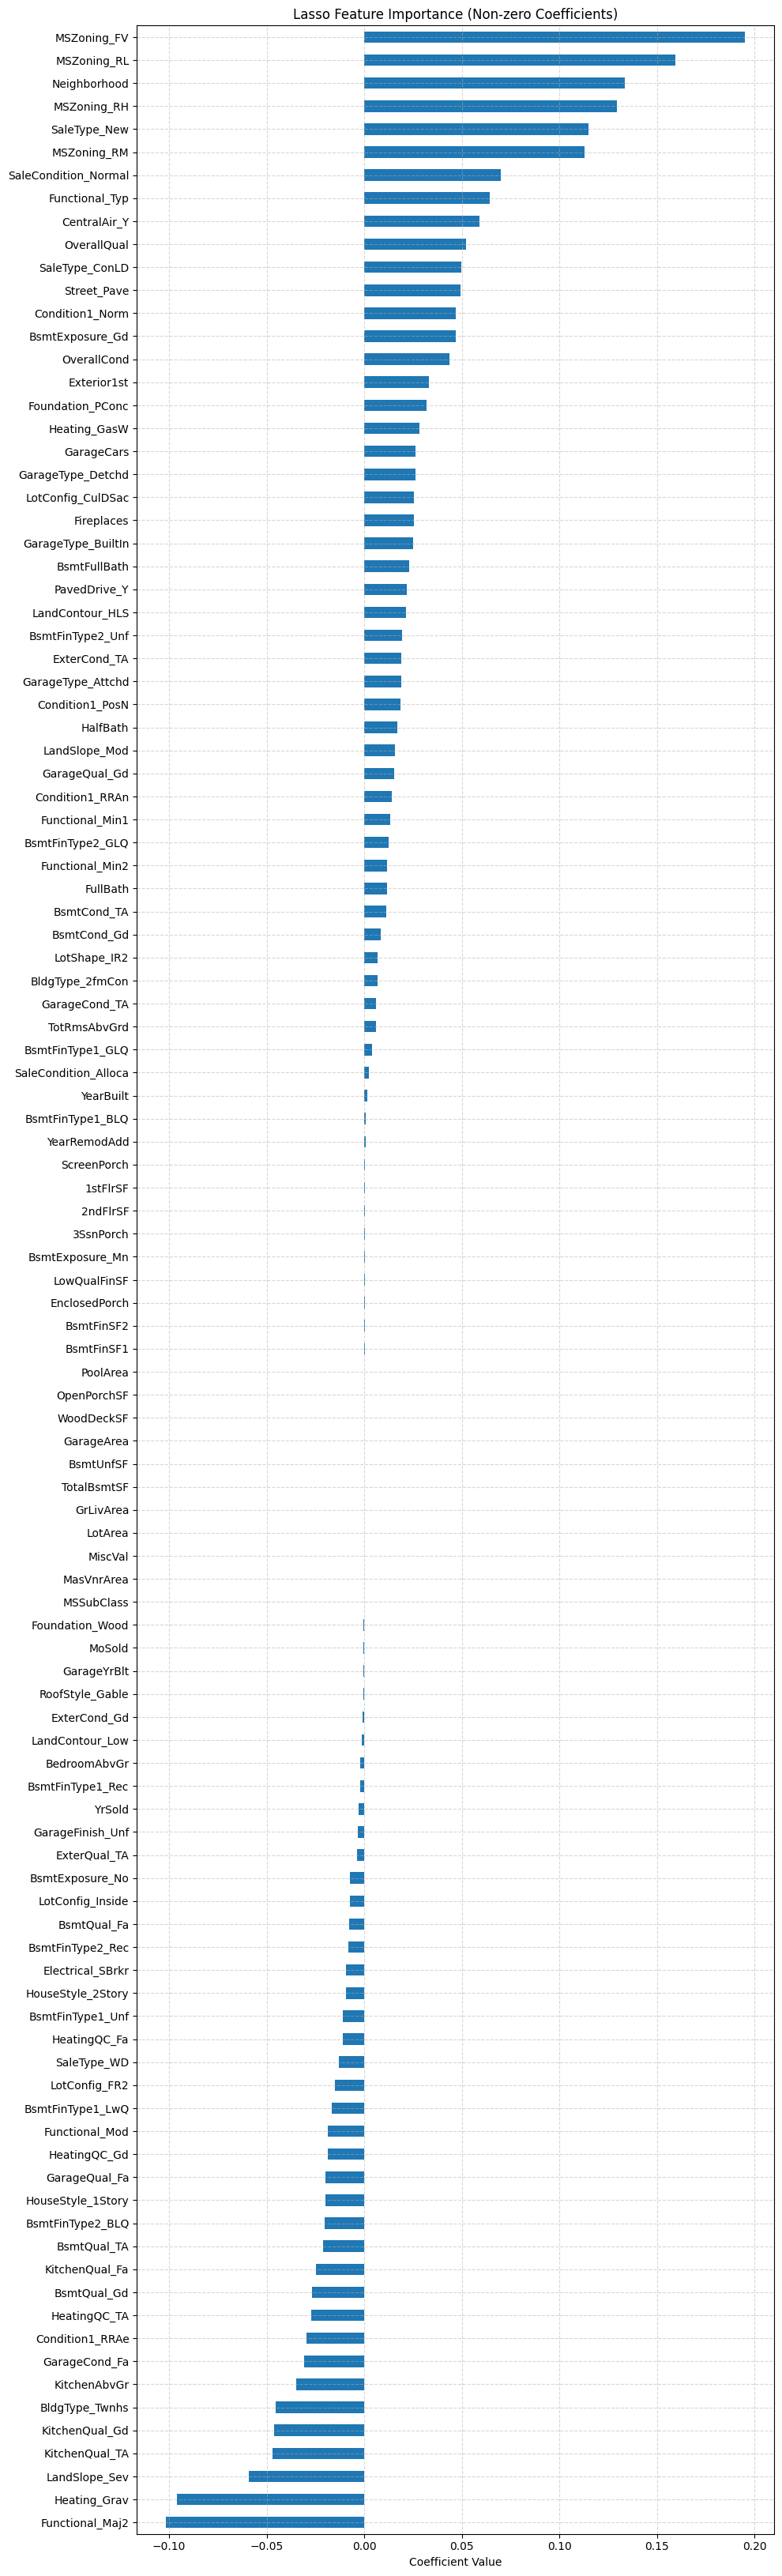

In [43]:
## Variable importance
# Get model coefficients
coefs = pd.Series(model_lasso.coef_, index=X_train_imputed.columns)

# Filter to only non-zero coefficients
non_zero_coefs = coefs[coefs != 0].sort_values()

plt.figure(figsize=(10, len(non_zero_coefs) * 0.3))
non_zero_coefs.plot(kind="barh")
plt.title("Lasso Feature Importance (Non-zero Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


MSZoning_FV             0.195141
MSZoning_RL             0.159550
Neighborhood            0.133333
MSZoning_RH             0.129544
SaleType_New            0.114752
MSZoning_RM             0.112772
Functional_Maj2         0.101732
Heating_Grav            0.095875
SaleCondition_Normal    0.070029
Functional_Typ          0.064224
LandSlope_Sev           0.058991
CentralAir_Y            0.058946
OverallQual             0.052119
SaleType_ConLD          0.049719
Street_Pave             0.049258
KitchenQual_TA          0.047086
Condition1_Norm         0.046845
BsmtExposure_Gd         0.046720
KitchenQual_Gd          0.046149
BldgType_Twnhs          0.045544
dtype: float64


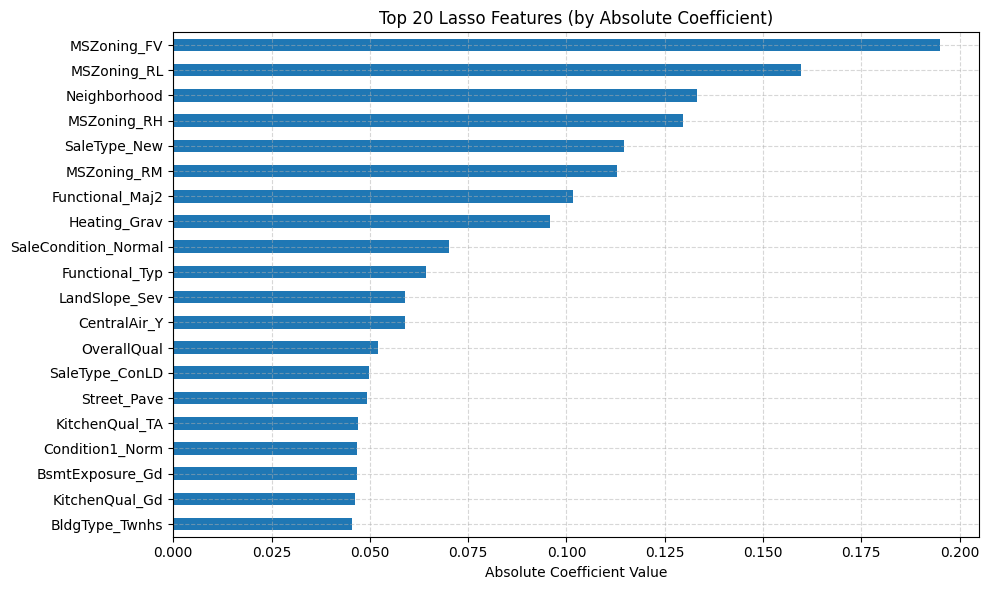

In [44]:
top_k = 20
top_features = non_zero_coefs.abs().sort_values(ascending=False).head(top_k)
print(top_features)

plt.figure(figsize=(10, top_k * 0.3))
top_features.sort_values().plot(kind="barh")
plt.title(f"Top {top_k} Lasso Features (by Absolute Coefficient)")
plt.xlabel("Absolute Coefficient Value")
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [45]:
# Step 1: Make sets of column names from each type
onehot_features = set(df_onehot.columns)
target_encoded_features = set(df_target.columns)
numeric_features = set(X_train.columns) - onehot_features - target_encoded_features

# Step 2: Classify top features
feature_types = []

for feat in top_features.index:
    if feat in onehot_features:
        feature_types.append("One-hot (categorical)")
    elif feat in target_encoded_features:
        feature_types.append("Target-encoded (categorical)")
    elif feat in numeric_features:
        feature_types.append("Numerical")
    else:
        feature_types.append("Unknown")

# Step 3: Combine into a DataFrame for easy viewing
feature_info = pd.DataFrame({
    "Feature": top_features.index,
    "Coefficient": top_features.values,
    "Feature Type": feature_types
})

feature_info


,Feature,Coefficient,Feature Type
0,MSZoning_FV,0.195141,One-hot (categorical)
1,MSZoning_RL,0.159550,One-hot (categorical)
2,Neighborhood,0.133333,Target-encoded (categorical)
3,MSZoning_RH,0.129544,One-hot (categorical)
4,SaleType_New,0.114752,One-hot (categorical)
5,MSZoning_RM,0.112772,One-hot (categorical)
6,Functional_Maj2,0.101732,One-hot (categorical)
7,Heating_Grav,0.095875,One-hot (categorical)
8,SaleCondition_Normal,0.070029,One-hot (categorical)
9,Functional_Typ,0.064224,One-hot (categorical)


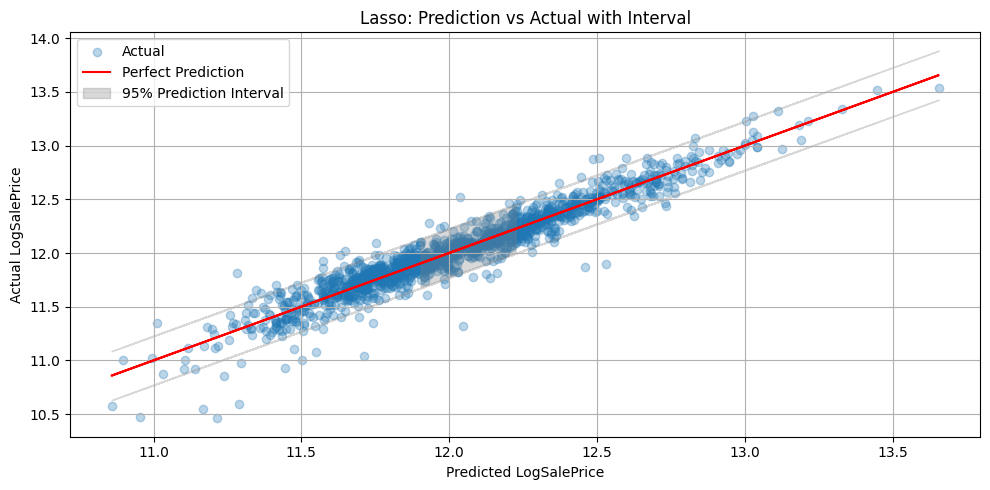

In [55]:
# prediction interval with logPrice

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
import numpy as np

# Get cross-validated predictions
cv_preds = cross_val_predict(model_lasso, X_train_imputed, y_train, cv=5)
residuals = y_train - cv_preds

# Calculate standard deviation of residuals
std_resid = np.std(residuals)

# 95% prediction interval (roughly: ±1.96 * std deviation)
lower_bound = cv_preds - 1.96 * std_resid
upper_bound = cv_preds + 1.96 * std_resid

plt.figure(figsize=(10, 5))
plt.scatter(cv_preds, y_train, alpha=0.3, label='Actual')
plt.plot(cv_preds, cv_preds, color='red', label='Perfect Prediction')
plt.fill_between(cv_preds, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Prediction Interval')

plt.xlabel('Predicted LogSalePrice')
plt.ylabel('Actual LogSalePrice')
plt.title('Lasso: Prediction vs Actual with Interval')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

   Predicted Price ($)  Lower Bound ($)  Upper Bound ($)
0               203798           162227           256023
1               200787           159829           252240
2               210362           167452           264269
3               158296           126006           198861
4               297034           236444           373152


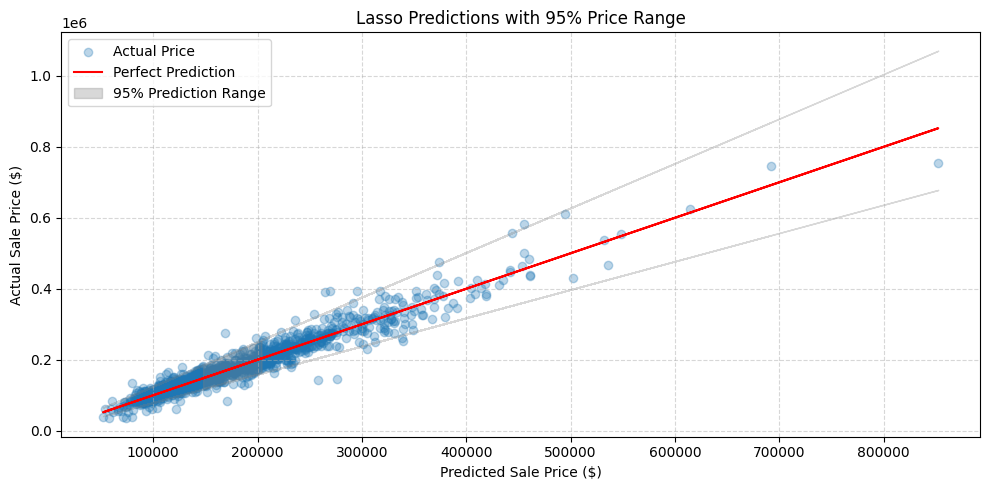

In [60]:
# Prediction interval on SalePrice
# Convert log predictions and intervals to actual price
pred_price = np.exp(cv_preds)
lower_price = np.exp(lower_bound)
upper_price = np.exp(upper_bound)

price_df = pd.DataFrame({
    'Predicted Price ($)': pred_price,
    'Lower Bound ($)': lower_price,
    'Upper Bound ($)': upper_price
})

price_df = price_df.round(0).astype(int)
print(price_df.head())

plt.figure(figsize=(10, 5))
plt.scatter(pred_price, np.exp(y_train), alpha=0.3, label='Actual Price')
plt.plot(pred_price, pred_price, color='red', label='Perfect Prediction')
plt.fill_between(pred_price, lower_price, upper_price, color='gray', alpha=0.3, label='95% Prediction Range')

plt.xlabel('Predicted Sale Price ($)')
plt.ylabel('Actual Sale Price ($)')
plt.title('Lasso Predictions with 95% Price Range')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Ensemble learning

- XGBoost captures non-linear interactions
- Lasso is sparse and linear — it captures clean, additive effects

In [46]:
# test data for Lasso model
# 1. test_numeric data
test_numeric = df_test.drop(columns = cat_cols.tolist() + ['Id'])

# 2. test_target encoding data
test_target = pd.DataFrame(index=df_test.index)

## global mean for new categories
global_mean = df_train['LogSalePrice'].mean()

for col in target:

    target_mean = df_train.groupby(col)['LogSalePrice'].mean() # Compute mean LogSalePrice per category using df_train

    test_target[col] = df_test[col].map(target_mean)           # Map the means onto the test set

    test_target[col] = test_target[col].fillna(global_mean)    # Fill unseen categories in test with the global mean

print(test_numeric.shape, test_onehot.shape, test_target.shape) # test_onehot has been done together with df_onehot


(1459, 35) (1459, 140) (1459, 3)


In [47]:
X_test = pd.concat([test_numeric, test_onehot, test_target], axis=1)
X_test_imputed = imputer.transform(X_test)

# Predict with both models
pred_xgb = np.exp(model.predict(x_test))  # exp() transform logPrice bacl to non-log price
pred_lasso = np.exp(model_lasso.predict(X_test_imputed))

# xbg has lower rmse in training
final_pred = 0.2 * pred_xgb + 0.8 * pred_lasso

In [48]:
# submission file
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': final_pred
})
submission.to_csv('submission6_xgb2_lasso8.csv', index = False)

In [49]:
submission.head(5)

,Id,SalePrice
0,1461,115468.957044
1,1462,148890.219774
2,1463,175543.641649
3,1464,194430.882893
4,1465,197169.762821


# V. Additional plots

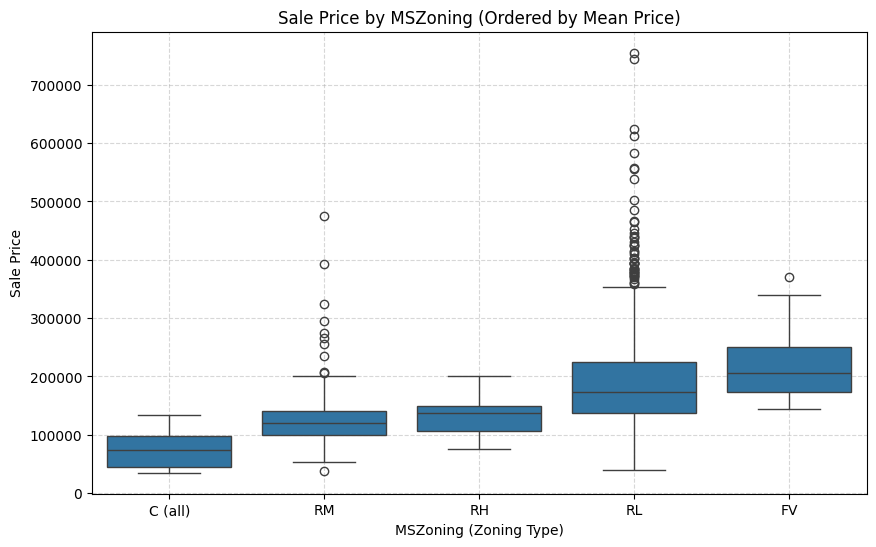

In [51]:
zone_order = df_train.groupby('MSZoning')['SalePrice'].mean().sort_values().index

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_train, x='MSZoning', y='SalePrice', order=zone_order)

plt.title('Sale Price by MSZoning (Ordered by Mean Price)')
plt.xlabel('MSZoning (Zoning Type)')
plt.ylabel('Sale Price')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

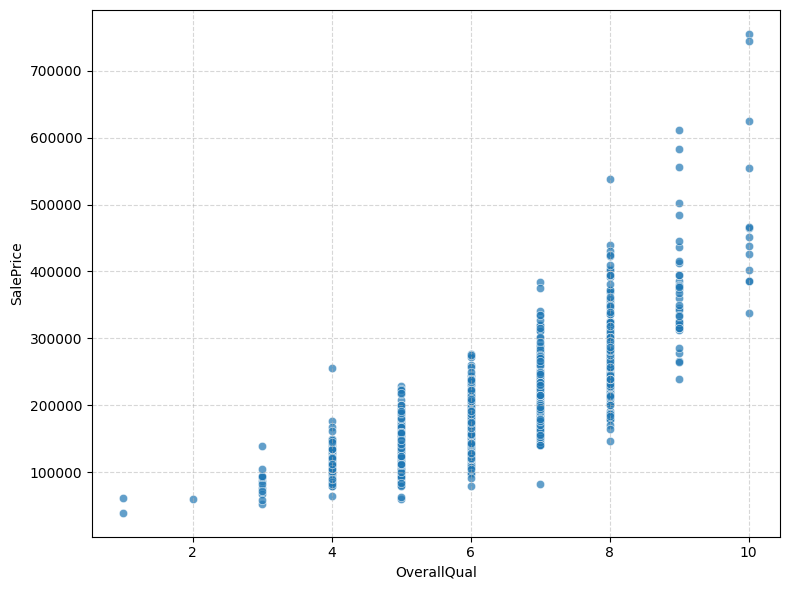

In [54]:
df_rl = df_train[df_train['MSZoning'] == 'RL']
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_rl, x='OverallQual', y='SalePrice', alpha=0.7)

plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()